Training and evaluating model...
Creating datasets...
Found 2679 files belonging to 44 classes.
Found 2490 files belonging to 44 classes.
Found 515 files belonging to 44 classes.
Found 44 classes: ['Apple', 'Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Brown-Cap-Mushroom', 'Cabbage', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Juice', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Melon', 'Milk', 'Mushroom', 'Nectarine', 'Oat-Milk', 'Oatghurt', 'Onion', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pear', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Potato', 'Red-Beet', 'Red-Grapefruit', 'Satsumas', 'Sour-Cream', 'Sour-Milk', 'Soy-Milk', 'Soyghurt', 'Tomato', 'Yoghurt', 'Zucchini']
Creating model...
Training model...
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5551 - loss: 1.8331 - val_accuracy: 0.7806 - val_loss: 0.7324 - learning_rate: 0.0010
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9610 - loss: 0.1413 - val_accuracy: 0.8136 - val_loss: 0

INFO:tensorflow:Assets written to: C:\Users\Bhavya\AppData\Local\Temp\tmpuysacg1j\assets


Saved artifact at 'C:\Users\Bhavya\AppData\Local\Temp\tmpuysacg1j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 44), dtype=tf.float32, name=None)
Captures:
  2145509873936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145509875472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145509875856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145509875664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145509874896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145478129232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145509874512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145509872592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145509876048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2145509876624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  214

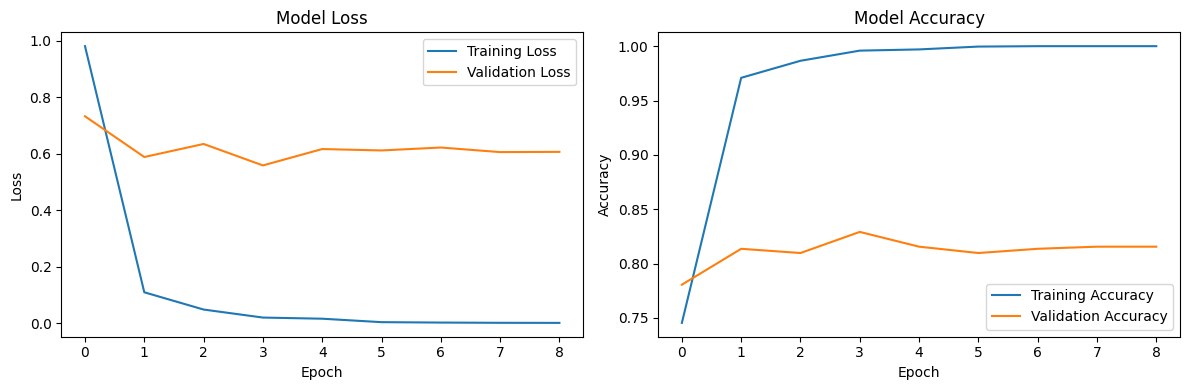

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Configuration
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

def create_model(num_classes):
    """Create a simplified model for classification only"""
    base_model = MobileNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

def create_dataset(data_dir):
    """Create a dataset from directory"""
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        label_mode='categorical',
        class_names=None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=True
    )
    
    # Get class names
    class_names = sorted(os.listdir(data_dir))
    
    # Preprocess dataset
    dataset = dataset.map(
        lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y)
    )
    
    return dataset, class_names

def evaluate_model(model, test_dataset, class_names):
    """Evaluate model on test dataset"""
    print("\nEvaluating model on test dataset...")
    test_results = model.evaluate(test_dataset, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    
    # Get predictions for confusion matrix
    all_predictions = []
    all_labels = []
    
    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)
        all_predictions.extend(predicted_classes)
        all_labels.extend(true_classes)
    
    # Print per-class accuracy
    print("\nPer-class accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = np.array(all_labels) == i
        if np.any(class_mask):
            class_acc = np.mean(np.array(all_predictions)[class_mask] == i)
            print(f"{class_name}: {class_acc:.4f}")

def train_and_evaluate_model():
    """Train and evaluate the model"""
    print("Creating datasets...")
    
    # Check if dataset directories exist
    if not os.path.exists('GroceryStoreDataset/train'):
        raise FileNotFoundError("Training dataset directory not found.")
    if not os.path.exists('GroceryStoreDataset/test'):
        raise FileNotFoundError("Test dataset directory not found.")
    
    # Create datasets
    train_dataset, class_names = create_dataset('GroceryStoreDataset/train')
    test_dataset, _ = create_dataset('GroceryStoreDataset/test')
    
    if os.path.exists('GroceryStoreDataset/val'):
        val_dataset, _ = create_dataset('GroceryStoreDataset/val')
    else:
        print("No validation directory found. Using training data split.")
        train_size = int(0.8 * len(train_dataset))
        val_dataset = train_dataset.skip(train_size)
        train_dataset = train_dataset.take(train_size)
    
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")
    
    # Configure datasets
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
    
    # Create and compile model
    print("Creating model...")
    model = create_model(num_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    print("Training model...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3
            )
        ]
    )
    
    # Evaluate on test dataset
    evaluate_model(model, test_dataset, class_names)
    
    # Convert to TFLite
    print("\nConverting to TFLite...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    with open('grocery_detector.tflite', 'wb') as f:
        f.write(tflite_model)
    
    # Save class names
    with open('class_names.txt', 'w') as f:
        for name in class_names:
            f.write(f"{name}\n")
    
    return class_names, history

def real_time_detection():
    """Perform real-time detection using webcam"""
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path='grocery_detector.tflite')
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Load class names
    with open('class_names.txt', 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
    
    # Start video capture
    cap = cv2.VideoCapture(0)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Preprocess frame
        input_frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        input_frame = tf.keras.applications.mobilenet_v2.preprocess_input(
            input_frame.astype(np.float32)
        )
        input_frame = np.expand_dims(input_frame, axis=0)
        
        # Perform detection
        interpreter.set_tensor(input_details[0]['index'], input_frame)
        interpreter.invoke()
        
        # Get results
        predictions = interpreter.get_tensor(output_details[0]['index'])
        
        # Process results
        class_idx = np.argmax(predictions[0])
        confidence = predictions[0][class_idx]
        
        # Draw results on frame
        if confidence > 0.5:  # Confidence threshold
            label = f"{class_names[class_idx]}: {confidence:.2f}"
            cv2.putText(frame, label, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Display frame
        cv2.imshow('Grocery Store Object Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    try:
        # Train and evaluate the model
        print("Training and evaluating model...")
        class_names, history = train_and_evaluate_model()
        
        # Plot training history
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        
        # Run real-time detection
        print("\nStarting real-time detection...")
        real_time_detection()
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please ensure your dataset is properly structured:")
        print("GroceryStoreDataset/")
        print("    train/")
        print("    val/ (optional)")
        print("    test/")